<a href="https://colab.research.google.com/github/surkovvv/Sample-DL-Repo/blob/HW5/StyleTransferSurkov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Перенос стилей

Почитать:
* [PyTorch, style transfer tutorial](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)
* [Оригинальная статья](https://arxiv.org/abs/1508.06576)

<img src="https://cdn-images-1.medium.com/max/1600/1*XI3beonBnOwp-y5BwNOqCw.gif" width="500">

**Quiz: как вы думаете, кто на картинке?**

# Основные принципы


1. Принимаем на вход 3 картинки: `content_image`, `style_image`, `input_image`;

2. Вводим два расстояния, которые конкретно определим позже:
 * $D_C$ (distance content) —  измеряет насколько близки по **контенту** 2 картинки;
 * $D_S$ (distance style) — измеряет насколько близки по **стилю** 2 картинки;

3. Для картинки `input_image` одновременно минимизируем расстояния $D_C$ до `content_image` и $D_S$ `style_image`: её входные пиксели можно просто считать обучаемыми параметрами, которые можно подобрать градиентным спуском

<img src="https://pytorch.org/tutorials/_images/neuralstyle.png">

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as transforms
import torchvision.models as models

import copy

Хоть нам и не нужно тут ничего обучать, GPU всё равно не помешает: чем мельче будут шаги, тем лучше получится результат.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Качаем картинки

<img src="https://thumbs.gfycat.com/FaithfulSickDuckbillcat-max-1mb.gif">



In [ ]:
!wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
!wget https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg

--2022-04-06 13:38:54--  https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
Resolving pytorch.org (pytorch.org)... 185.199.111.153, 185.199.109.153, 185.199.108.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114573 (112K) [image/jpeg]
Saving to: ‘picasso.jpg’

picasso.jpg         100%[===================>] 111.89K  --.-KB/s    in 0.02s   

2022-04-06 13:38:55 (5.47 MB/s) - ‘picasso.jpg’ saved [114573/114573]

--2022-04-06 13:38:55--  https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
Resolving pytorch.org (pytorch.org)... 185.199.111.153, 185.199.109.153, 185.199.108.153, ...
Connecting to pytorch.org (pytorch.org)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40484 (40K) [image/jpeg]
Saving to: ‘dancing.jpg’

dancing.jpg         100%[===================>]  39.54K  --.-KB/s    in 0.003s  

2022-04-06 13:38:55 (12.1 MB/s)

In [3]:
# уменьшаем картинки
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize(imsize), # уменьшаем картинку
    transforms.ToTensor()])  # делаем из картинки тензор


def image_loader(image_name):
    image = Image.open(image_name)
    # создаем фейковый дименшн для батча
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("./Picasso_Woman.jpeg")
#content_img = image_loader("./mila.jpeg")
#content_img = image_loader("./while_cat.jpeg")
content_img = image_loader("./clown.jpeg")

assert style_img.size() == content_img.size(), \
    "Картинки для стиля и для контента должны быть одного размера"


Конвертируем картинку обратно из тензора в формат `PIL` и показываем ее с помощью `plt.imshow()`.

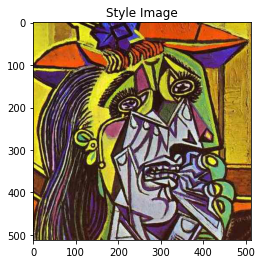

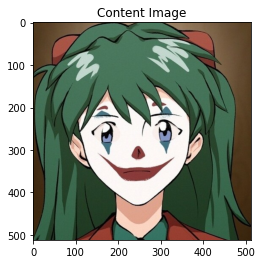

In [4]:
unloader = transforms.ToPILImage()  # конвертируем в `PIL image`

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)      # убираем лишнюю размерность батча
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
#     plt.pause(0.001)


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## Loss

### Content Loss

* Принимаем на вход фичи из прошлого сверточного слоя для `content_image` — $F_{CL}$ — и то же самое для input_image — $F_{XL}$. Считаем расстояние между ними и называем это $D_C^L(X,C) = \|F_{XL} - F_{CL}\|^2$. 
* Расстояние считаем с помощью `nn.MSELoss`.
* Реализуем все это дело как модуль. Само расстояние $D_C^L(X,C)$ в нем хранится как параметр.

In [5]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super().__init__()
        # detach() используется, чтобы не считать градиенты до target
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

### Style Loss

* Берем матрицу $F_{XL}$, размерностью $[a,b,c,d]$, делаем размерность $[a\cdot b, c \cdot d]$
* Считаем матрицу Грама $G_{XL}$ для этой матрицы: это перемножение матрицы на свою транспонированную копию.
* Нормализуем матрицу Грама: делим каждое ее значение на полное количество элементов в матрице. Это необходимо сделать, чтобы операция получения матрицы Грама не повлияла на повышение активации нейронов.

In [6]:
# upd: возможно, эта штука уже есть где-то в pytorch

def gram_matrix(input):
    a, b, c, d = input.size()  
    # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f.map(N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

Модуль для `StyleLoss` выглядит также, как модуль для `ContentLoss`,

с той разницей, что теперь MSE считается для двух матриц Грама $\|G_{XL}$ - $G_{SL}\|^2$, а не для активаций слоев непосредственно.



In [7]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Используем предобученную модель

<img src="https://cdn-images-1.medium.com/max/1600/1*Fe6z8VdUS6laTd6Ev3EohQ.gif">

Импортируем наш любимый vgg и ставим его в режим `eval()` — в нём некоторые слои работают по-разному в режимах предсказания и обучения.

В оригинальной статье про NST использовали vgg19, что автор и будет, но при желании можете использовать вашу любимую свёрточную сеть, если корректно подберете параметры.

In [8]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]


Как и в тетрадке про Deep Dream, используем `mean=[0.485, 0.456, 0.406]` и `std=[0.229, 0.224, 0.225]`, так как оригинальная VGG обучалась с такими параметрами препроцессинга для входных данных.

In [9]:
# upd: эта штука тоже уже должна быть где-нибудь в pytorch

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Делаем модуль для нормализации, чтобы потом без труда стакать в слои
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

Мы создаем новый `Sequential` модуль содержащий те же модули, что и `vgg19.features`, только теперь нам нужно добавить наш лосс после каждого сверточного слоя, который мы хотим использовать.

In [10]:
# Какие именно слои мы хотим использовать чтобы считать наши лоссы
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # помним, что сначала нормализуем картинки
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # хотим иметь iterable с вставленными модулями
    content_losses = []
    style_losses = []

    # создаем свою модельку, в которую вставим лоссы
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # добавляем content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # добавляем style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # Обрезаем все слои, которые находятся после последнего ContentLoss или StyleLoss
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Чаще всего в качестве `input_image` используется та же картинка что и `content_image`. Но также можно использовать и шумную картинку и посмотреть что получится тогда.


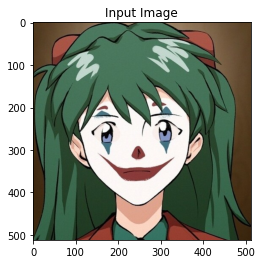

In [11]:
input_img = content_img.clone()

# если есть желание подать шум, попробуйте эту строчку раскомментить
# input_img = torch.randn(content_img.data.size(), device=device)

plt.figure()
imshow(input_img, title='Input Image')

Gradient Descent
----------------

Оптимизируем `input_image` используя `L-BFGS` оптимизатор, как советует автор оригинальной статьи вот [здесь](https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq).


In [12]:
def get_input_optimizer(input_img):
    # input_img - это параметры, до которых доходит градиент
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

# Finally

<img src="http://rux.vc/wp-content/uploads/2016/08/cat-out-2.gif">

* Итеративно меняем `input_image`; для того параметр `num_steps`;
* Можно менять веса стиля и веса контента `style_weight`, `content_weight`;
* Корректируем значения картинки так, чтобы они не выходили за пределы `[0..1]`
* В функции `closure` мы собираем весь лосс из всех модулей, считаем градиенты.
* Затем обновляем параметры модели с помощью `optimizer.step(closure)`

In [13]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=320,
                       style_weight=1000000, content_weight=1):
    """ Поехали! """
    
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean,
                                                                     normalization_std,
                                                                     style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # корректируем значения, чтобы они лежали в пределах `[0..1]`
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # корректируем значения, чтобы они лежали в пределах `[0..1]` для финальной картинки
    input_img.data.clamp_(0, 1)

    return input_img

Запускаем!


Building the style transfer model..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


Optimizing..
run [50]:
Style Loss : 167.132538 Content Loss: 29.077057

run [100]:
Style Loss : 54.857937 Content Loss: 30.207922

run [150]:
Style Loss : 22.361320 Content Loss: 29.547913

run [200]:
Style Loss : 10.495198 Content Loss: 27.993431

run [250]:
Style Loss : 5.903927 Content Loss: 26.464302

run [300]:
Style Loss : 3.971373 Content Loss: 25.103374

with coef 1000000 and 1


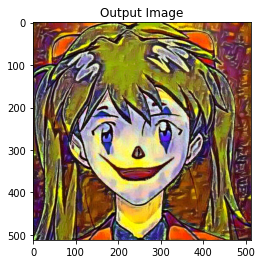

In [14]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

# plt.figure()
print("with coef 1000000 and 1")
imshow(output, title='Output Image')

# plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


run [50]:
Style Loss : 107.936958 Content Loss: 219.552185

run [100]:
Style Loss : 47.678459 Content Loss: 190.886047

run [150]:
Style Loss : 33.239185 Content Loss: 182.246948

run [200]:
Style Loss : 33.768822 Content Loss: 178.621902

run [250]:
Style Loss : 19.736105 Content Loss: 184.880524

run [300]:
Style Loss : 31.457380 Content Loss: 189.262878

500000 10


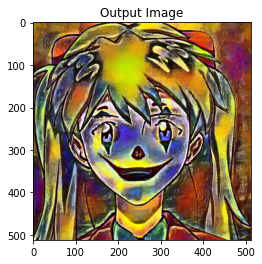

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 4.968431 Content Loss: 21.908871

run [100]:
Style Loss : 2.698523 Content Loss: 21.015457

run [150]:
Style Loss : 2.435188 Content Loss: 20.324207

run [200]:
Style Loss : 2.064618 Content Loss: 22.515291

run [250]:
Style Loss : 1.532725 Content Loss: 20.530928

run [300]:
Style Loss : 1.425453 Content Loss: 19.799461

500000 1


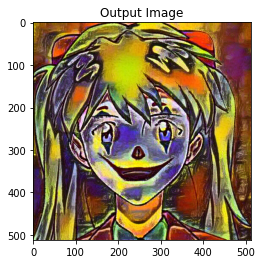

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 6.657179 Content Loss: 20.804102

run [100]:
Style Loss : 4.068104 Content Loss: 21.556946

run [150]:
Style Loss : 2.990920 Content Loss: 21.781670

run [200]:
Style Loss : 2.457915 Content Loss: 21.811676

run [250]:
Style Loss : 2.131941 Content Loss: 21.818333

run [300]:
Style Loss : 1.936121 Content Loss: 21.773495

5000000 1


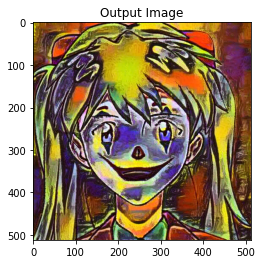

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 8.706195 Content Loss: 199.679993

run [100]:
Style Loss : 10.274894 Content Loss: 193.916260

run [150]:
Style Loss : 13.899848 Content Loss: 190.786972

run [200]:
Style Loss : 13.384997 Content Loss: 190.734070

run [250]:
Style Loss : 15.392543 Content Loss: 191.711914

run [300]:
Style Loss : 19.060226 Content Loss: 192.591217

5000000 10


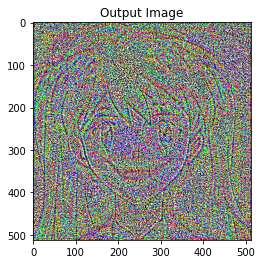

In [17]:
from itertools import combinations
for style_weight, content_weight in [(500000, 10), (500000, 1), (5000000, 1), (5000000, 10)]:
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, 322, style_weight, content_weight)
    # plt.figure()
    print(style_weight, content_weight)
    imshow(output, title='Output Image')

    # plt.ioff()
    plt.show()

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


run [50]:
Style Loss : 145624.546875 Content Loss: 96935.531250

run [100]:
Style Loss : 141060.859375 Content Loss: 92955.867188

run [150]:
Style Loss : 139156.265625 Content Loss: 110428.617188

run [200]:
Style Loss : 123298.859375 Content Loss: 211544.656250

run [250]:
Style Loss : 117705.937500 Content Loss: 402672.250000

run [300]:
Style Loss : 262008400.000000 Content Loss: 51988060.000000

10000000 100000


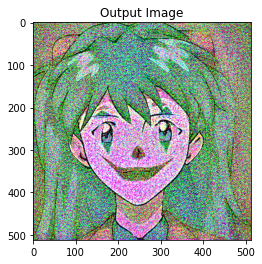

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 5025.526855 Content Loss: 16518.814453

run [100]:
Style Loss : 4811.229980 Content Loss: 16934.214844

run [150]:
Style Loss : 6711.659180 Content Loss: 20075.271484

run [200]:
Style Loss : 13819201.000000 Content Loss: 139448.296875

run [250]:
Style Loss : 165011248.000000 Content Loss: 370286.312500

run [300]:
Style Loss : 6621.361328 Content Loss: 37179.109375

10000000 1000


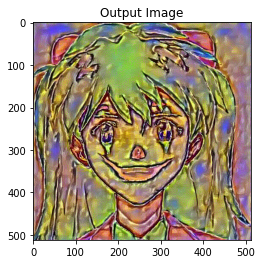

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 603.702026 Content Loss: 419.144592

run [100]:
Style Loss : 250.689041 Content Loss: 434.531128

run [150]:
Style Loss : 136.154999 Content Loss: 425.899292

run [200]:
Style Loss : 90.881203 Content Loss: 412.697144

run [250]:
Style Loss : 56.533264 Content Loss: 402.490173

run [300]:
Style Loss : 42.525688 Content Loss: 390.795746

10000000 10


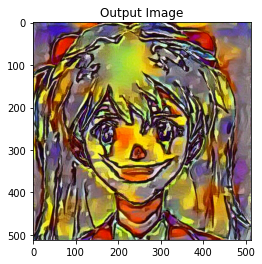

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 24.342514 Content Loss: 39.468906

run [100]:
Style Loss : 17.777830 Content Loss: 40.520721

run [150]:
Style Loss : 13.429394 Content Loss: 41.047371

run [200]:
Style Loss : 10.880767 Content Loss: 41.199833

run [250]:
Style Loss : 18.334780 Content Loss: 41.034199

run [300]:
Style Loss : 7.191458 Content Loss: 40.955025

10000000 1


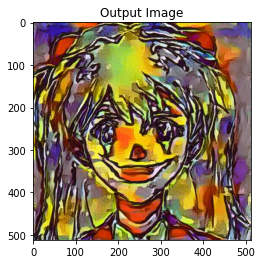

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 5.409766 Content Loss: 4.111561

run [100]:
Style Loss : 4.569025 Content Loss: 4.183269

run [150]:
Style Loss : 3.900122 Content Loss: 4.249436

run [200]:
Style Loss : 3.282671 Content Loss: 4.302757

run [250]:
Style Loss : 2.789507 Content Loss: 4.345239

run [300]:
Style Loss : 4.147449 Content Loss: 4.382442

10000000 0.1


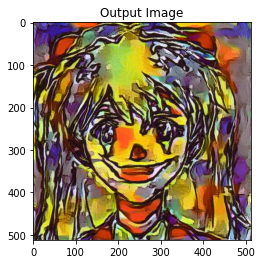

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 1330.247192 Content Loss: 2234.773193

run [100]:
Style Loss : 1281.971802 Content Loss: 2391.130371

run [150]:
Style Loss : 1308.094360 Content Loss: 3541.715088

run [200]:
Style Loss : 1323.179199 Content Loss: 8343.672852

run [250]:
Style Loss : 2086.800293 Content Loss: 15357.140625

run [300]:
Style Loss : 5804.929199 Content Loss: 23832.591797

100000 1000


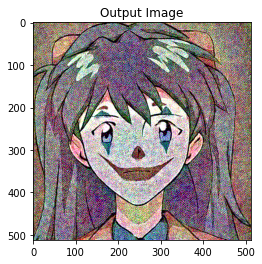

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 47.456608 Content Loss: 156.205704

run [100]:
Style Loss : 93.160683 Content Loss: 184.945618

run [150]:
Style Loss : 373.803070 Content Loss: 212.337250

run [200]:
Style Loss : 89.634918 Content Loss: 193.634033

run [250]:
Style Loss : 3927205.000000 Content Loss: 5866.542480

run [300]:
Style Loss : 151.698380 Content Loss: 450.662994

100000 10


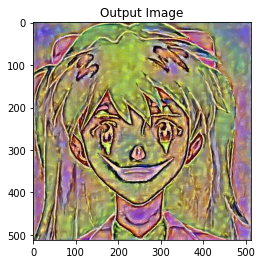

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 10.116835 Content Loss: 42.331337

run [100]:
Style Loss : 5.173509 Content Loss: 40.233383

run [150]:
Style Loss : 5.194016 Content Loss: 37.681450

run [200]:
Style Loss : 2.422919 Content Loss: 35.878685

run [250]:
Style Loss : 2.231648 Content Loss: 33.847633

run [300]:
Style Loss : 2.347764 Content Loss: 31.871685

100000 1


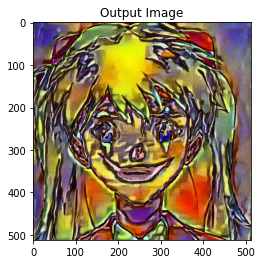

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 0.592593 Content Loss: 3.211286

run [100]:
Style Loss : 0.352548 Content Loss: 3.209019

run [150]:
Style Loss : 0.293242 Content Loss: 3.182040

run [200]:
Style Loss : 0.223051 Content Loss: 3.144248

run [250]:
Style Loss : 2813509.500000 Content Loss: 51.572548

run [300]:
Style Loss : 934960.937500 Content Loss: 31.127100

100000 0.1


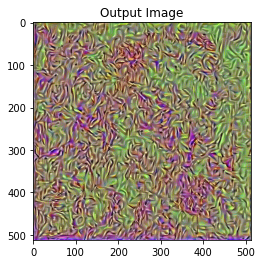

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 13.025162 Content Loss: 17.638866

run [100]:
Style Loss : 13.528421 Content Loss: 16.358696

run [150]:
Style Loss : 12.778155 Content Loss: 20.763756

run [200]:
Style Loss : 11.478786 Content Loss: 30.802717

run [250]:
Style Loss : 13.290748 Content Loss: 87.696304

run [300]:
Style Loss : 14.511591 Content Loss: 104.076462

1000 10


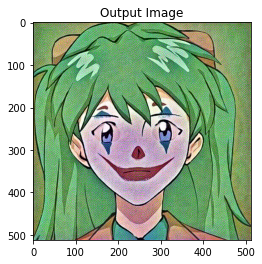

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 6.021025 Content Loss: 12.205574

run [100]:
Style Loss : 22444.916016 Content Loss: 463.175720

run [150]:
Style Loss : 7.602627 Content Loss: 15.829130

run [200]:
Style Loss : 5.233061 Content Loss: 11.589508

run [250]:
Style Loss : 6.409115 Content Loss: 16.948250

run [300]:
Style Loss : 243.710007 Content Loss: 104.674065

1000 1


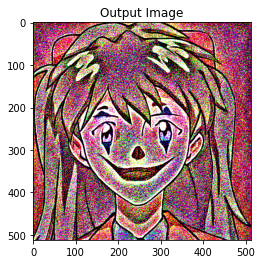

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 0.445758 Content Loss: 1.496300

run [100]:
Style Loss : 0.366689 Content Loss: 1.549673

run [150]:
Style Loss : 0.670554 Content Loss: 1.840757

run [200]:
Style Loss : 8.179270 Content Loss: 2.636450

run [250]:
Style Loss : 36295.617188 Content Loss: 54.959911

run [300]:
Style Loss : 1.935793 Content Loss: 4.770027

1000 0.1


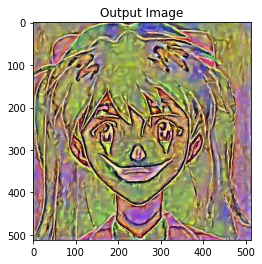

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 0.193820 Content Loss: 1.608033

run [100]:
Style Loss : 0.191742 Content Loss: 0.977526

run [150]:
Style Loss : 0.201201 Content Loss: 0.387605

run [200]:
Style Loss : 0.205723 Content Loss: 0.303492

run [250]:
Style Loss : 0.170743 Content Loss: 8.352082

run [300]:
Style Loss : 0.189244 Content Loss: 2.164388

10 1


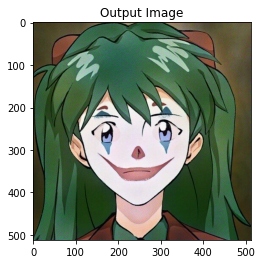

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 0.141230 Content Loss: 0.086252

run [100]:
Style Loss : 0.131477 Content Loss: 0.123393

run [150]:
Style Loss : 0.121585 Content Loss: 0.201225

run [200]:
Style Loss : 0.125079 Content Loss: 0.138576

run [250]:
Style Loss : 0.139843 Content Loss: 0.940669

run [300]:
Style Loss : 0.117391 Content Loss: 0.377807

10 0.1


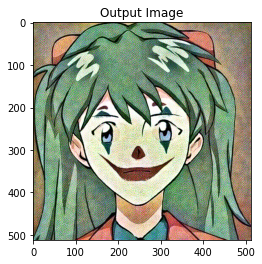

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 0.018901 Content Loss: 0.059657

run [100]:
Style Loss : 0.019699 Content Loss: 0.034299

run [150]:
Style Loss : 0.020039 Content Loss: 0.022284

run [200]:
Style Loss : 0.020385 Content Loss: 0.016118

run [250]:
Style Loss : 0.020550 Content Loss: 0.024900

run [300]:
Style Loss : 0.020522 Content Loss: 0.029959

1 0.1


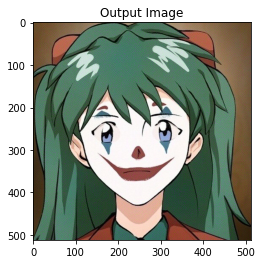

In [16]:
from itertools import combinations
for style_weight, content_weight in combinations([0.1, 1, 10, 1000, 100000, 10000000][::-1], 2):
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, 322, style_weight, content_weight)
    # plt.figure()
    print(style_weight, content_weight)
    imshow(output, title='Output Image')

    # plt.ioff()
    plt.show()

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


run [50]:
Style Loss : 4.116045 Content Loss: 3.235259

run [100]:
Style Loss : 2.585453 Content Loss: 3.346001

run [150]:
Style Loss : 1.812499 Content Loss: 3.431841

run [200]:
Style Loss : 1.391729 Content Loss: 3.434938

run [250]:
Style Loss : 1.076774 Content Loss: 3.391784

run [300]:
Style Loss : 0.910780 Content Loss: 3.346769

1000000 0.1


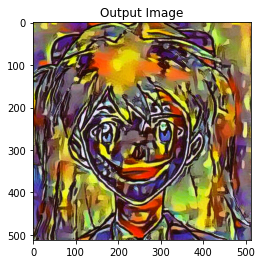

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 1.399915 Content Loss: 25.086916

run [100]:
Style Loss : 3.883723 Content Loss: 22.479162

run [150]:
Style Loss : 2.148726 Content Loss: 21.261396

run [200]:
Style Loss : 2.354079 Content Loss: 20.389786

run [250]:
Style Loss : 2.786173 Content Loss: 20.086884

run [300]:
Style Loss : 2.420000 Content Loss: 21.916521

100000 1


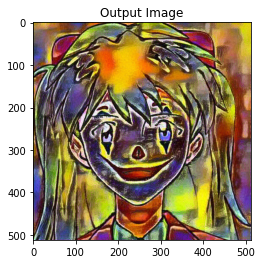

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 6.155624 Content Loss: 22.162045

run [100]:
Style Loss : 3.316783 Content Loss: 22.054771

run [150]:
Style Loss : 2.307636 Content Loss: 21.750549

run [200]:
Style Loss : 1.938251 Content Loss: 21.433094

run [250]:
Style Loss : 1.698887 Content Loss: 21.235279

run [300]:
Style Loss : 4.302907 Content Loss: 20.967735

1000000 1


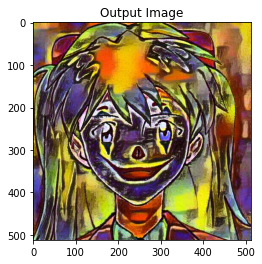

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 8.796695 Content Loss: 2.209787

run [100]:
Style Loss : 5.896525 Content Loss: 2.340485

run [150]:
Style Loss : 4.211831 Content Loss: 2.456476

run [200]:
Style Loss : 3.300029 Content Loss: 2.531168

run [250]:
Style Loss : 2.687751 Content Loss: 2.594327

run [300]:
Style Loss : 2.156595 Content Loss: 2.639072

10000000 0.1


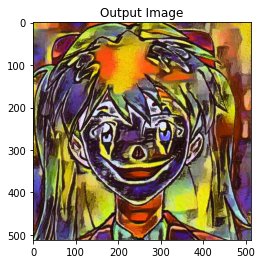

In [17]:
for style_weight, content_weight in [(1000000, 0.1), (100000, 1), (1000000, 1), (10000000, 0.1)]:
    
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, 322, style_weight, content_weight)
    print(style_weight, content_weight)
    imshow(output, title='Output Image')

    # plt.ioff()
    plt.show()

# Сложно оценивать, тут все более-менее похожи, но мне больше всего нравится с параметрами 1000000, 1, как наиболее кислотная, но похожая. Если присмотреться, то даже волосы покрываются "плиткой"